In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

In [2]:
df = pd.read_csv('Data\WMT.csv')
df

,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828
...,...,...
5474,2020-12-25,NaN
5475,2020-12-28,142.946777
5476,2020-12-29,142.041183
5477,2020-12-30,141.923065


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [4]:
df = df[(df['Date'].dt.year>=2010) & (df['Date'].dt.year <=2020)]

In [5]:
df = df.set_index('Date')
df = df.asfreq('B')

In [6]:
df.isnull().sum()

Adj Close    101
dtype: int64

In [7]:
df = df.ffill()

Had one null left so I dropped it.

In [8]:
df.isnull().sum()

Adj Close    1
dtype: int64

In [9]:
df.dropna(subset=['Adj Close'], inplace=True)

In [10]:
df

,Adj Close
Date,
2010-01-04,40.963638
2010-01-05,40.555729
2010-01-06,40.465084
2010-01-07,40.487759
2010-01-08,40.283802
...,...
2020-12-25,141.253738
2020-12-28,142.946777
2020-12-29,142.041183


<Axes: xlabel='Date'>

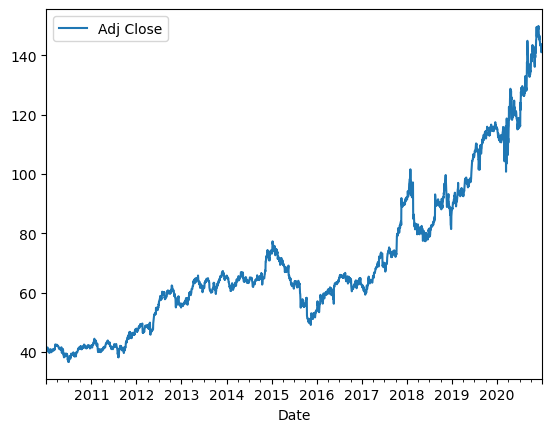

In [11]:
df.plot()

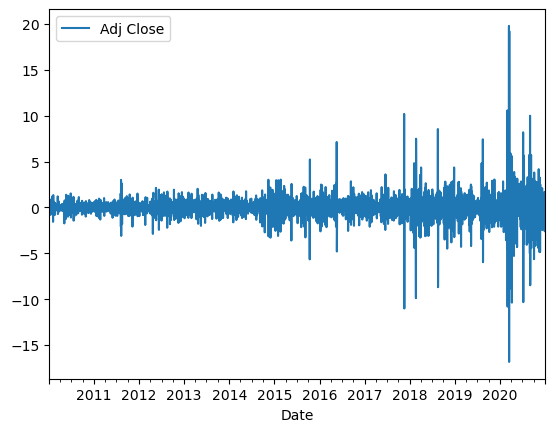

In [12]:
df.diff().diff().plot();

In [13]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [14]:
get_adfuller_results(df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.436262,23,2845,0.997273,0.05,False


In [15]:
get_adfuller_results(df.diff().dropna())

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.215558,22,2845,0.0,0.05,True


In [16]:
get_adfuller_results(df.diff().diff().dropna())

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-18.757916,28,2838,0.0,0.05,True


Need to difference once

In [17]:
ndiffs(df)

1

In [18]:
df_diff1= df.diff().diff().dropna()

In [19]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig


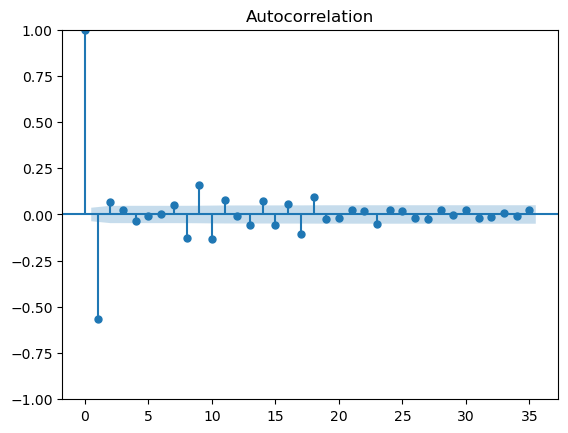

In [20]:
tsa.graphics.plot_acf(df_diff1);

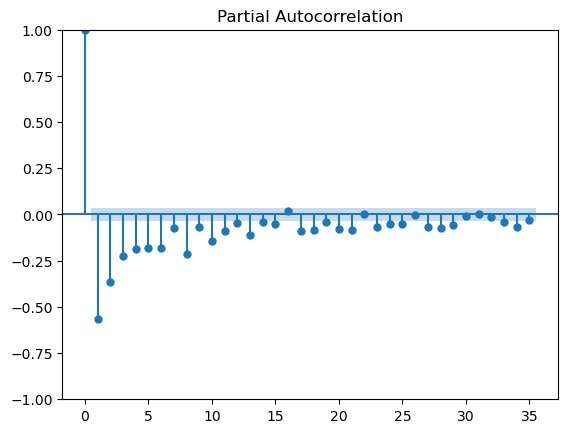

In [21]:
tsa.graphics.plot_pacf(df_diff1['Adj Close']);

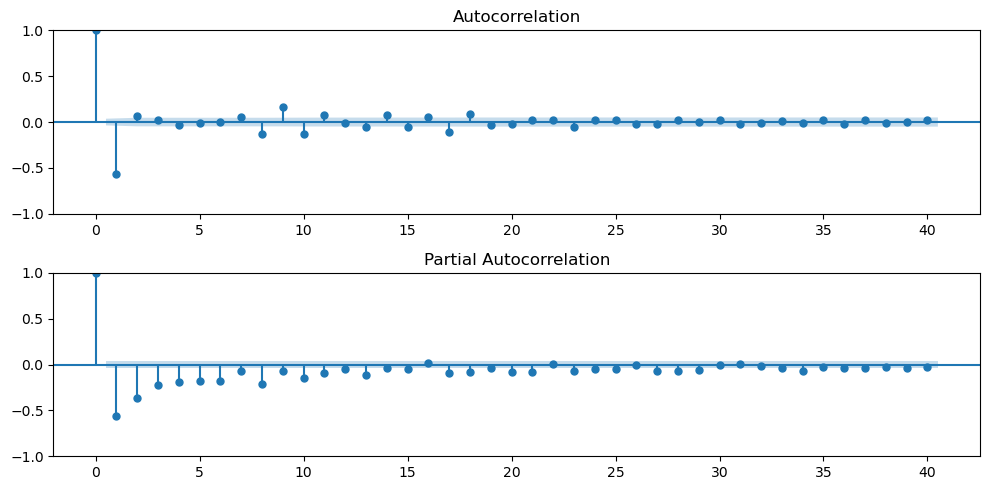

In [22]:
plot_acf_pacf(df_diff1);

In [23]:
train, test = train_test_split(df, test_size = 65)


## First Model

In [24]:
p = 0
d = 1
q = 2

arima_model = tsa.ARIMA(df, order=(p,q,d)).fit()

In [25]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2869
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -4031.149
Date:                Fri, 01 Dec 2023   AIC                           8066.299
Time:                        18:18:15   BIC                           8078.221
Sample:                    01-04-2010   HQIC                          8070.597
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9993      0.001   -771.379      0.000      -1.002      -0.997
sigma2         0.9723      0.006    154.973      0.000       0.960       0.985
===================================================================================
Ljung-Box (L1) (Q):                  44.78   Jarque-Bera (JB):            118947.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.12   Skew:                             1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [27]:
predictions = arima_model.get_forecast(steps=len(test)).summary_frame()

In [28]:
regression_metrics_ts(test, predictions['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.815
- MSE = 10.862
- RMSE = 3.296
- R^2 = 0.155
- MAPE = 1.97%


MAPE under 2%

In [30]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

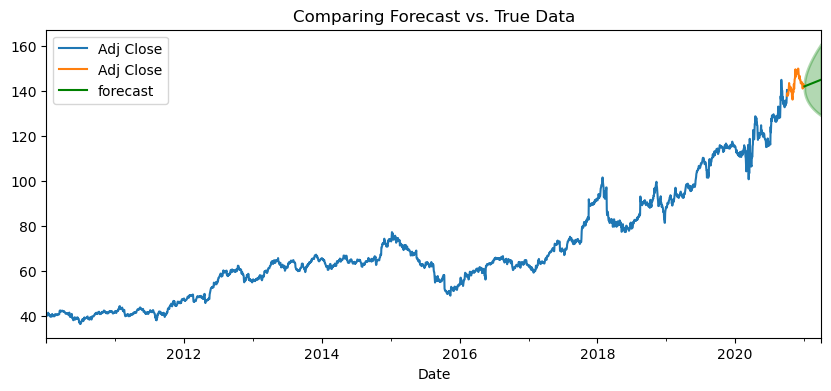

In [32]:
plot_forecast(train, test, predictions);

## Second Model

In [33]:
p = 0
d = 2
q = 1

arima_model2 = tsa.ARIMA(df, order=(p,q,d)).fit()

In [34]:
arima_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2869
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -4007.984
Date:                Fri, 01 Dec 2023   AIC                           8021.968
Time:                        18:25:39   BIC                           8039.852
Sample:                    01-04-2010   HQIC                          8028.416
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1222      0.006    -19.659      0.000      -0.134      -0.110
ma.L2          0.0227      0.006      3.568      0.000       0.010       0.035
sigma2         0.9580      0.007    144.985      0.000       0.945       0.971
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            102268.09
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              10.77   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
predictions2 = arima_model2.get_forecast(steps=len(test)).summary_frame()

In [36]:
regression_metrics_ts(test, predictions2['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.004
- MSE = 14.339
- RMSE = 3.787
- R^2 = -0.115
- MAPE = 2.08%


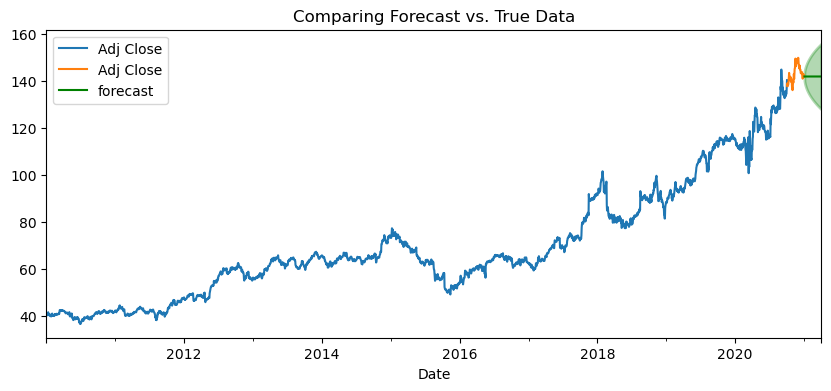

In [37]:
plot_forecast(train, test, predictions2);

Based off of MAPE the first model was pretty good. 
Visually the first model seems more of a natural fit as opposed to the second model which doesn't seem to follow.